In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import andreap
from scipy.interpolate import interp1d

import importlib.util
import sys

In [72]:
test_index = 0
validation_set = False

In [73]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../nuCOMET/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_training_data", "../../nuCOMET/generate_training_data.py")
gtd = importlib.util.module_from_spec(spec)
sys.modules["generate_training_data"] = gtd
spec.loader.exec_module(gtd)

In [74]:
hc = np.load("hc_backup_i4999_massive_pred_revised.npy",
    allow_pickle=True)
samples = np.load("samples_backup_i4999_massive_pred_revised.npy",
    allow_pickle=True)

if validation_set:
    hc = np.load("hc_backup_i4999_massive_test_revised.npy",
        allow_pickle=True)
    samples = np.load("samples_backup_i4999_massive_test_revised.npy",
        allow_pickle=True)
    
standard_k = np.load("standard_k.npy", allow_pickle=True)

In [75]:
test_cosmology = hc[test_index]
test_pspec = samples[test_index]

In [76]:
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [77]:
full_cosm = gtd.build_cosmology(ombh2, omch2, ns, sigma12, As, omnuh2)

In [78]:
mnu = full_cosm['mnu']

In [79]:
Pk_lo_h = andreap.get_PK(ombh2, omch2, ns, mnu, 10, As)
Pk_hi_h = andreap.get_PK(ombh2, omch2, ns, mnu, 67, As)
Pk_target_h = andreap.get_PK(ombh2, omch2, ns, mnu, 57, As)

0.008207
1
massive-neutrino sigma12 [1.32106989]
massless-neutrino sigma12 [1.6588811]
0.008207
1
massive-neutrino sigma12 [0.74706875]
massless-neutrino sigma12 [0.93389778]
0.008207
1
massive-neutrino sigma12 [0.80262619]
massless-neutrino sigma12 [1.00397832]


In [80]:
z = np.linspace(0., 5., 500)
sig12 = np.zeros(500)
for i in range(500):
    sig12[i] = andreap.get_s12(Pk_hi_h['mzero'], z[i])

In [81]:
sigma12

0.9719207949661621

In [82]:
sig12[0]

0.9338976410228134

In [83]:
sig12_interpolator = interp1d(sig12, z, kind='cubic')

In [84]:
g_pspec, g_sigma12, g_z = gtd.psz(full_cosm, standard_k)
print("This is our approximation", g_sigma12)

Discrepancy between maximal achievable sigma12 and target -0.037992402479654075
Desired 0.9719207949661621
Discrepancy between maximal achievable sigma12 and target 0.03209074114659405
Desired 0.9719207949661621
We had to move h to 0.57
This is our approximation 0.9719215919408176


In [85]:
import copy as cp
tilde_cosm = cp.deepcopy(full_cosm)
tilde_cosm['omch2'] += tilde_cosm['omnuh2']
tilde_cosm = ci.specify_neutrino_mass(tilde_cosm, 0, 0)
gtd.print_cosmology(tilde_cosm)
print()
gtd.print_cosmology(full_cosm)

ombh2 0.023080185000000003
omch2 0.11757400000000001
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.5700000000000001
w0 -1.0
wa 0.00
sigma12 0.9719207949661621
omnuh2 0
mnu 0.0

ombh2 0.023080185000000003
omch2 0.109367
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.5700000000000001
w0 -1.0
wa 0.00
sigma12 0.9719207949661621
omnuh2 0.008207
mnu 0.763278082362583


In [86]:
kci_t, zci_t, pci_t, sci_t = ci.kzps(tilde_cosm, redshifts=[g_z], k_points=300)
kci, zci, pci, sci = ci.kzps(full_cosm, redshifts=[g_z], k_points=300)

In [87]:
sci

array([0.77719023])

In [88]:
g_pspec_t, g_sigma12_t, g_z_t = gtd.psz(tilde_cosm, standard_k)
print("This is our approximation", g_sigma12_t)

Discrepancy between maximal achievable sigma12 and target 0.03209074114659405
Desired 0.9719207949661621
We had to move h to 0.57
This is our approximation 0.9719215919408176


In [89]:
andreap.get_s12(Pk_hi_h['mzero'], 0)

0.9338976410228134

In [90]:
# I cannot figure out how to get AndreaP's function to work
#andreap.get_s12_fixedz(Pk_hi_h['mzero'])

In [91]:
tilde_cosm

Name           Columbus_0
ombh2             0.02308
omch2            0.117574
n_s              0.946505
A_s                   0.0
OmB                  0.05
OmC              0.268584
OmM              0.318584
OmK                   0.0
OmL              0.681416
h                    0.57
w0                   -1.0
wa                   0.00
EOmDE                   -
z(4)                  2.0
z(3)                  1.0
z(2)                 0.57
z(1)                  0.3
z(0)                  0.0
Lbox               1000.0
sigma8            0.82755
sigma12          0.971921
omnuh2                  0
mnu                   0.0
nnu_massive             0
Name: 0, dtype: object

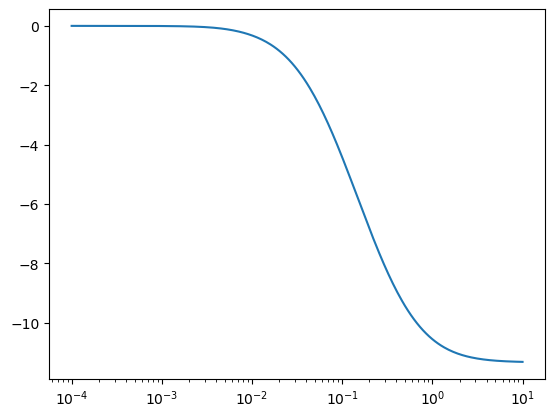

In [92]:
plt.plot(standard_k, (pci - samples[test_index]) / samples[test_index] * 100)
plt.xscale('log')

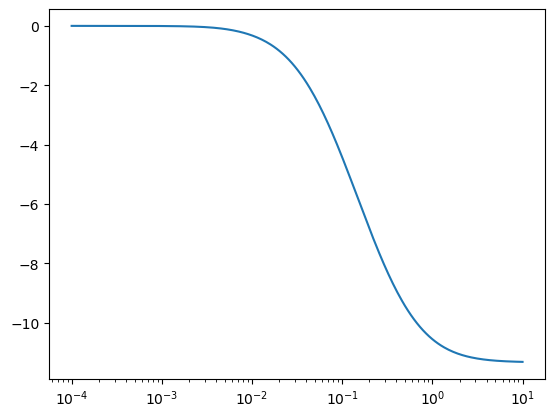

In [93]:
plt.plot(standard_k, (g_pspec - samples[test_index]) / samples[test_index] * 100)
plt.xscale('log')

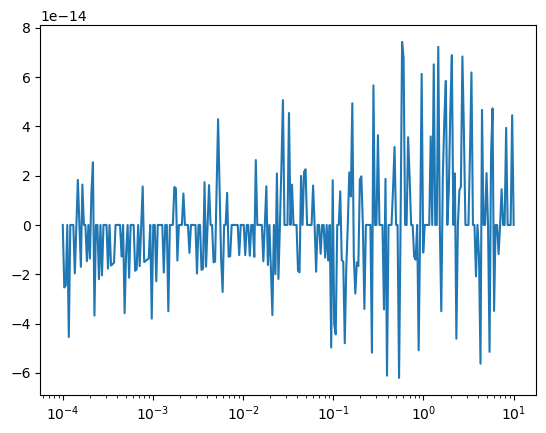

In [94]:
plt.plot(standard_k, (pci - g_pspec) / pci * 100)
plt.xscale('log')